In [43]:
from sklearn.model_selection import train_test_split, KFold,ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

In [44]:
df = pd.read_csv('ready_to_train.csv')

In [45]:
df.columns

Index(['price', 'link', 'rooms', 'total_area', 'kitchen_area', 'floor',
       'renovation', 'house_type', 'passenger_lift', 'cargo_lift', 'parking',
       'city', 'floors_total', 'smart_floor_ratio', 'house_age',
       'city_specific_age_group', 'age_city_premium', 'is_spb_historical'],
      dtype='object')

In [ ]:
X = df.drop(['price','link'], axis=1)
y = df['price']
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True
)
y_log = np.log1p(y)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


In [47]:
X.columns

Index(['rooms', 'total_area', 'kitchen_area', 'floor', 'renovation',
       'house_type', 'passenger_lift', 'cargo_lift', 'parking', 'city',
       'floors_total', 'smart_floor_ratio', 'house_age',
       'city_specific_age_group', 'age_city_premium', 'is_spb_historical'],
      dtype='object')

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
import numpy as np

def optimize_catboost(trial, X, y):
    """Оптимизация CatBoost через Optuna"""
    param = {
        'iterations': trial.suggest_int('iterations', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 2),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 20),
    }
    
    model = CatBoostRegressor(**param, verbose=False,cat_features=categorical_cols)
    score = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    return score


# Быстрая оптимизация, можно запустить если есть время
def quick_optimization(X, y, n_trials=10):
    """Быстрая оптимизация параметров"""
    
    study_catboost = optuna.create_study(direction='maximize')
    study_catboost.optimize(lambda trial: optimize_catboost(trial, X, y), n_trials=n_trials)
    
    return {
        'catboost_best': study_catboost.best_params,
    }

best_params = quick_optimization(X, y_log)

[I 2025-11-23 18:19:46,326] A new study created in memory with name: no-name-a8c6173f-c496-4a81-89d1-bc93db9b2004


🔍 Запуск быстрой оптимизации параметров...


[I 2025-11-23 18:21:14,055] Trial 0 finished with value: -0.27564182770430723 and parameters: {'iterations': 816, 'learning_rate': 0.1227075104752227, 'depth': 7, 'l2_leaf_reg': 3.6173403026748367, 'random_strength': 0.7203930859791073, 'bagging_temperature': 0.3582416155957412, 'min_data_in_leaf': 19}. Best is trial 0 with value: -0.27564182770430723.
[I 2025-11-23 18:22:29,434] Trial 1 finished with value: -0.26970174408841574 and parameters: {'iterations': 594, 'learning_rate': 0.15117849988651214, 'depth': 8, 'l2_leaf_reg': 8.290694307177972, 'random_strength': 0.8750950916204077, 'bagging_temperature': 0.8377870044041246, 'min_data_in_leaf': 15}. Best is trial 1 with value: -0.26970174408841574.
[I 2025-11-23 18:23:02,060] Trial 2 finished with value: -0.24918565209776541 and parameters: {'iterations': 467, 'learning_rate': 0.11539704621514346, 'depth': 5, 'l2_leaf_reg': 1.7645387213837678, 'random_strength': 1.1535110689997563, 'bagging_temperature': 0.6926131135293292, 'min_data

In [ ]:
def get_cv_strategies(n_splits=5, random_state=42):
    """Возвращает различные стратегии CV"""
    
    strategies = {
        'KFold': KFold(n_splits=n_splits, shuffle=True,),
        'ShuffleSplit': ShuffleSplit(n_splits=n_splits, test_size=0.2, ),
    }
    
    return strategies

def evaluate_model_cv(model, X, y, cv_strategy, model_name=""):
    """Оценка модели с кросс-валидацией"""
    
    print(f"\n--- Оценка {model_name} ---")
    
    scoring = {
        'neg_mae': 'neg_mean_absolute_error',
        'neg_rmse': 'neg_mean_squared_error',
        'r2': 'r2'
    }
    
    cv_results = {}
    for metric_name, metric_scoring in scoring.items():
        scores = cross_val_score(model, X, y, cv=cv_strategy, 
                               scoring=metric_scoring, n_jobs=-1)
        cv_results[metric_name] = scores
        
        if metric_name == 'neg_mae':
            print(f"MAE: {-scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        elif metric_name == 'neg_rmse':
            rmse_scores = np.sqrt(-scores)
            print(f"RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std() * 2:.4f})")
        elif metric_name == 'r2':
            print(f"R2: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    
    return cv_results

In [ ]:

models = {
    'CatBoostRegressor': CatBoostRegressor(**best_params,cat_features=categorical_cols)
}

cv_strategies = get_cv_strategies(n_splits=5)

results = {}

for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"МОДЕЛЬ: {model_name}")
    print(f"{'='*50}")
    
    model_results = {}
    for strategy_name, cv_strategy in cv_strategies.items():
        print(f"\nСтратегия: {strategy_name}")
        cv_scores = evaluate_model_cv(model, X_train, y_train_log, cv_strategy, f"{model_name}_{strategy_name}")
        model_results[strategy_name] = cv_scores
    
    results[model_name] = model_results


МОДЕЛЬ: CatBoostRegressor

Стратегия: KFold

--- Оценка CatBoostRegressor_KFold ---
MAE: 0.1653 (+/- 0.0065)
RMSE: 0.2161 (+/- 0.0121)
R2: 0.8329 (+/- 0.0149)

Стратегия: ShuffleSplit

--- Оценка CatBoostRegressor_ShuffleSplit ---
MAE: 0.1624 (+/- 0.0051)
RMSE: 0.2174 (+/- 0.0184)
R2: 0.8263 (+/- 0.0175)


In [ ]:
def final_training_and_evaluation(best_model, X_train, y_train_log, X_test, y_test_log, y_test_original):
    """Финальное обучение и оценка на тестовом наборе"""
    
    best_model.fit(X_train, y_train_log)
    
    y_pred_log = best_model.predict(X_test)
    y_pred_original = np.expm1(y_pred_log)
    
    metrics = {
        'MAE': mean_absolute_error(y_test_original, y_pred_original),
        'RMSE': np.sqrt(mean_squared_error(y_test_original, y_pred_original)),
        'R2': r2_score(y_test_original, y_pred_original),
        'MAPE': np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
    }
    
    print("\nФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ НА ТЕСТЕ:")
    for metric, value in metrics.items():
        if metric == 'MAPE':
            print(f"{metric}: {value:.2f}%")
        else:
            print(f"{metric}: {value:.4f}")
    
    return y_pred_original, metrics

def plot_predictions(y_true, y_pred, model_name):
    """Визуализация предсказаний"""
    
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Реальная цена')
    plt.ylabel('Предсказанная цена')
    plt.title(f'{model_name} - Предсказания vs Реальность')
    
    plt.subplot(1, 2, 2)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Предсказанная цена')
    plt.ylabel('Остатки')
    plt.title(f'{model_name} - Остатки')
    
    plt.tight_layout()
    plt.show()

0:	learn: 0.4411646	total: 15ms	remaining: 7.29s
1:	learn: 0.3817707	total: 29.3ms	remaining: 7.08s
2:	learn: 0.3388860	total: 44ms	remaining: 7.08s
3:	learn: 0.3090040	total: 58.6ms	remaining: 7.06s
4:	learn: 0.2881211	total: 74.5ms	remaining: 7.16s
5:	learn: 0.2725472	total: 89.3ms	remaining: 7.15s
6:	learn: 0.2624553	total: 105ms	remaining: 7.16s
7:	learn: 0.2541374	total: 124ms	remaining: 7.4s
8:	learn: 0.2489056	total: 146ms	remaining: 7.73s
9:	learn: 0.2443139	total: 173ms	remaining: 8.22s
10:	learn: 0.2406268	total: 193ms	remaining: 8.35s
11:	learn: 0.2380209	total: 211ms	remaining: 8.33s
12:	learn: 0.2363085	total: 225ms	remaining: 8.19s
13:	learn: 0.2347243	total: 246ms	remaining: 8.29s
14:	learn: 0.2329564	total: 270ms	remaining: 8.46s
15:	learn: 0.2309883	total: 285ms	remaining: 8.38s
16:	learn: 0.2296300	total: 296ms	remaining: 8.18s
17:	learn: 0.2284138	total: 312ms	remaining: 8.1s
18:	learn: 0.2272998	total: 325ms	remaining: 8s
19:	learn: 0.2263209	total: 339ms	remaining:

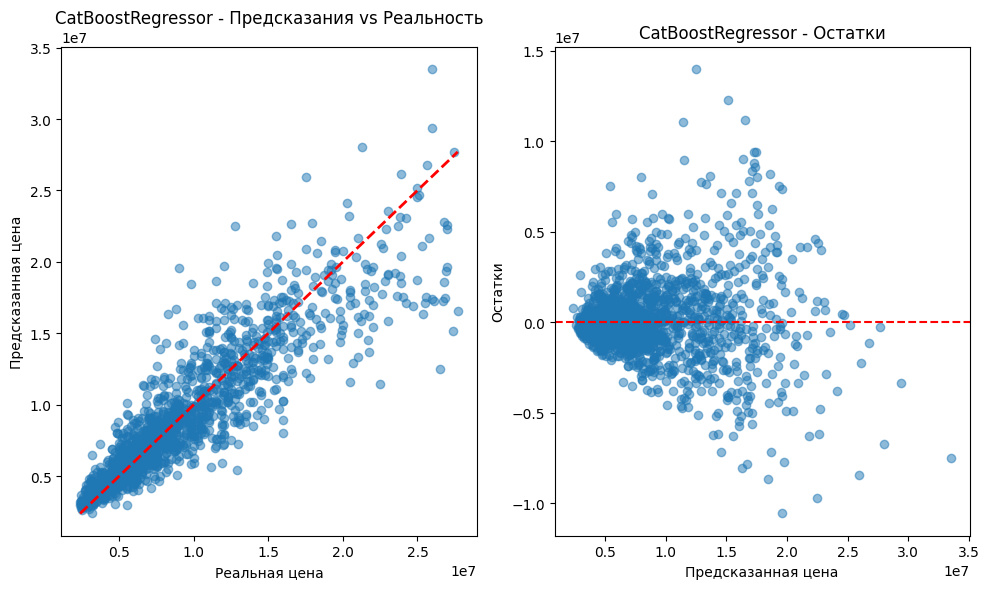

['best_real_estate_model.pkl']

In [ ]:
best_model_name = 'CatBoostRegressor' 
best_model = models[best_model_name]

y_pred, final_metrics = final_training_and_evaluation(
    best_model, X_train, y_train_log, X_test, y_test_log, y_test
)

plot_predictions(y_test, y_pred, best_model_name)

import joblib
joblib.dump(best_model, 'best_real_estate_model.pkl')

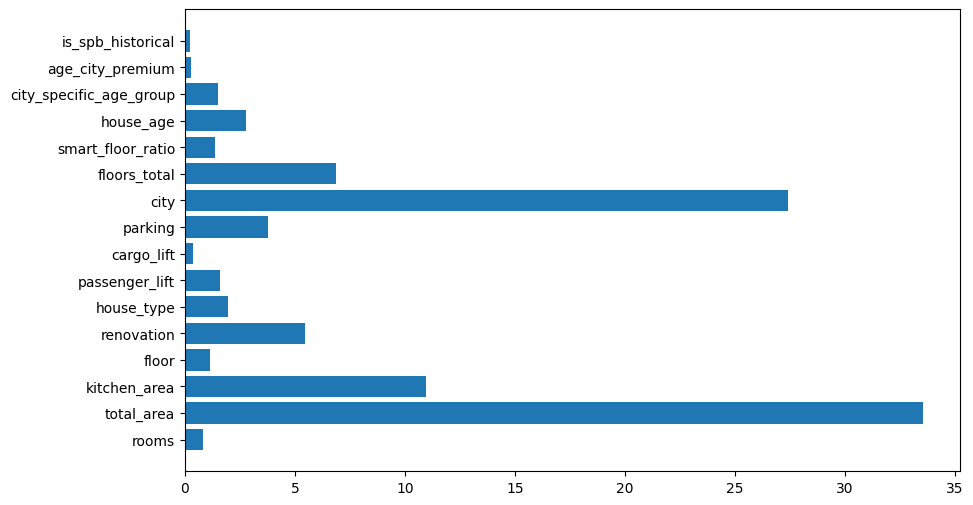

In [53]:
import matplotlib.pyplot as plt

importance = best_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importance)
plt.show()

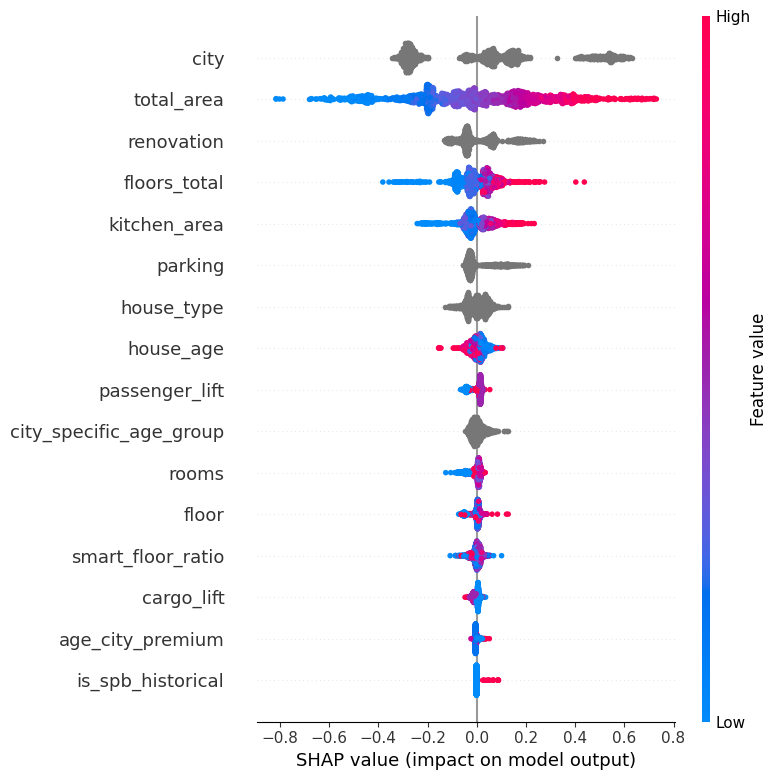

In [55]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
feature_names = X_train.columns

# Визуализация
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

# Отбор признаков с наибольшим средним |SHAP|
shap_importance = np.abs(shap_values).mean(axis=0)
top_features = X_test.columns[np.argsort(shap_importance)[::-1][:20]]